### Introduction
This program is designed to predict wave heights using time-series data, applying advanced machine learning techniques to oceanographic measurements. Accurate wave height forecasting is crucial for a variety of maritime activities, such as navigation, port operations, and coastal management. The goal of this project is to develop a predictive model that can forecast wave heights based on historical oceanographic data, including variables like wave height, wind speed, and atmospheric pressure.

By utilizing Long Short-Term Memory (LSTM) networks, a type of deep learning model specifically designed for sequence prediction, the program captures the temporal dependencies within the data. The process begins with data preprocessing and normalization to ensure the model receives clean and scaled input. The model is then trained on historical data, where it learns to predict future wave heights based on previous observations.

This predictive model can offer valuable insights for improving safety in maritime activities, as well as for proactive coastal planning. With the ability to forecast wave conditions, this tool helps mitigate risks and optimize decision-making for various ocean-related operation

This cell imports libraries for:

Data manipulation (pandas, numpy),
Data normalization (MinMaxScaler),
Splitting the data into training and test sets (train_test_split),
Creating an LSTM (Long Short-Term Memory) model for time series data (tensorflow.keras),
Visualizing results with graphs (matplotlib.pyplot).


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Loads wave data from a CSV file and displays the column names and the first rows to verify the file was imported correctly.

In [2]:
# Chargement des données
df = pd.read_csv('C:\\Users\\Pc\\Downloads\\Wave measurement from 01 12 2023 to 30 09 2024.csv') 
print(df.columns)
print(df)

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')
                Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                      NaN        NaN        NaN        NaN        NaN   
1                      NaN        NaN        NaN        NaN        NaN   
2                      NaN        NaN        NaN        NaN        NaN   
3                      NaN        NaN        NaN        NaN        NaN   
4                      NaN        NaN        NaN        NaN        NaN   
...                    ...        ...        ...        ...        ...   
38951  09/29/2024 10:10:00    1.15234    327.223    10.6667    1.08793   
38952  09/29/2024 10:20:00    

C:\Users\Pc\AppData\Local\Temp\ipykernel_13184\236513073.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\Pc\\Downloads\\Wave measurement from 01 12 2023 to 30 09 2024.csv')


Cleans the data by removing rows with non-numeric values in the Unnamed: 1 column (which appears to be wave heights). It then displays the first rows to confirm the filtering worked.

In [3]:
df = df[pd.to_numeric(df['Unnamed: 1'], errors='coerce').notnull()]

# Vérifiez après suppression
print(df.head())

             Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  \
15  12/01/2023 00:10:00      0.745    298.716      11.13        NaN   
16  12/01/2023 00:20:00      0.711    293.716      11.13        NaN   
17  12/01/2023 00:30:00      0.723    302.929      11.13        NaN   
18  12/01/2023 00:40:00      0.757    302.775      10.24        NaN   
19  12/01/2023 00:50:00      0.766    300.296      10.24        NaN   

   Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 12  \
15        NaN        NaN        NaN        NaN        NaN  ...         NaN   
16        NaN        NaN        NaN        NaN        NaN  ...         NaN   
17        NaN        NaN        NaN        NaN        NaN  ...         NaN   
18        NaN        NaN        NaN        NaN        NaN  ...         NaN   
19        NaN        NaN        NaN        NaN        NaN  ...         NaN   

   Unnamed: 13 Unnamed: 14 Unnamed: 15 Unnamed: 16 Unnamed: 17 Unnamed: 18  \
15         NaN         NaN

Normalizes the Unnamed: 1 column (wave height) so the values are between 0 and 1. 
This helps stabilize the LSTM model training and improve its performance.



In [5]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
wave_height_scaled = scaler.fit_transform(df[['Unnamed: 1']])

Defines a function to split the data into sequences of sequence_length (here, 60) to predict the wave height for a given day using the 60 previous days.
Creates sequence (X) and target (y) datasets.
Splits the data into training and testing sets (80% for training, 20% for testing).


In [6]:

# Création de séquences (découpage des données en sous-séquences de taille fixe)
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)

# Paramètres
sequence_length = 60  # Prédire la prochaine valeur à partir des 60 dernières minutes
X, y = create_sequences(wave_height_scaled, sequence_length)

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Builds an LSTM model by adding layers:
A first LSTM layer with 50 units and a sequence output (return_sequences=True),
A Dropout layer (20%) to prevent overfitting,
A second LSTM layer without sequence output,
A Dense layer with 25 units and a final Dense output layer with 1 unit.
Compiles the model using the adam optimizer and the mean_squared_error loss function.
Trains the model for 20 epochs with a batch size of 64, using validation data to assess performance.


In [7]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))



C:\Users\Pc\anaconda3\envs\tenserflow\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 71s 128ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 66s 137ms/step - loss: 0.0013 - val_loss: 7.0121e-04
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - loss: 9.5642e-04 - val_loss: 6.6610e-04
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 62s 128ms/step - loss: 8.3442e-04 - val_loss: 6.7691e-04
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - loss: 7.8515e-04 - val_loss: 7.2740e-04
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 61s 126ms/step - loss: 7.2839e-04 - val_loss: 4.9524e-04
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 60s 123ms/step - loss: 6.7802e-04 - val_loss: 4.2476e-04
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - loss: 6.3624e-04 - val_loss: 3.5530e-04
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - loss: 5.8105e-04 - val_loss: 3.0273e-04
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 62s 127ms/step - loss: 5.3451e-04 - val_loss: 3.8671e-04
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 

Uses the model to predict wave heights on the test set.
Reverses the normalization to get predictions in the original units (wave height in meters).


In [8]:
# Prédiction sur les données de test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverser la normalisation pour obtenir les vraies valeurs

243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step


Displays two plots:
A graph of the actual wave heights versus predictions to visualize the model's accuracy.
A graph of the training and validation loss curves to monitor the model's error over epochs.


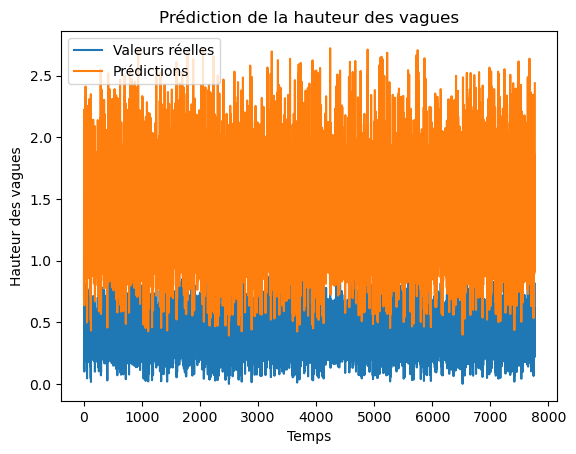

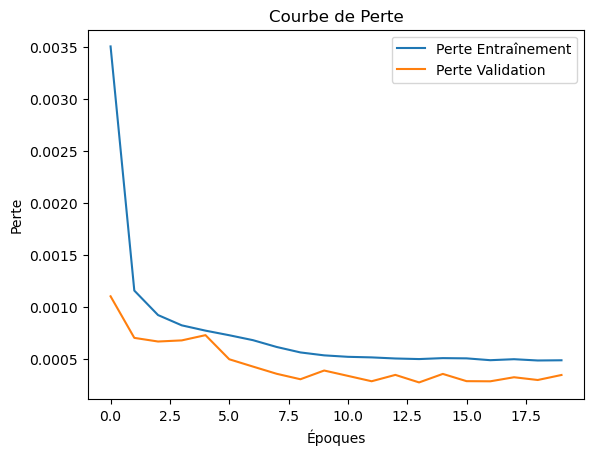

In [9]:
# Visualisation des résultats
plt.plot(y_test, label='Valeurs réelles')
plt.plot(predictions, label='Prédictions')
plt.xlabel('Temps')
plt.ylabel('Hauteur des vagues')
plt.title('Prédiction de la hauteur des vagues')
plt.legend()
plt.show()

# Visualisation de la perte durant l'entraînement
plt.plot(history.history['loss'], label='Perte Entraînement')
plt.plot(history.history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbe de Perte')
plt.legend()
plt.show()

Creates a function that checks if a given date exists in the data, then uses the 60 previous days to predict the wave height for that date.
Normalizes the input sequence, makes the prediction, and reverses the normalization to get the result in the original units.

In [10]:

# Fonction pour prédire la hauteur des vagues à partir d'un jour spécifique
def predict_wave_height(model, df, scaler, target_date, sequence_length=60):
    # Vérifier si la date existe dans le DataFrame
    
    if target_date not in df['Unnamed: 0'].values:
        print(f"La date {target_date} n'existe pas dans les données.")
        return

    # Obtenez l'index de la date donnée
    target_index = df[df['Unnamed: 0'] == target_date].index[0]

    # Sélectionner les 60 derniers jours avant cette date
    if target_index < sequence_length:
        print("Les données sont insuffisantes pour prédire à partir de cette date.")
        return

    # Sélectionner la séquence de 60 jours avant cette date
    input_sequence = df.iloc[target_index - sequence_length: target_index]['Unnamed: 1'].values
    input_sequence = scaler.transform(input_sequence.reshape(-1, 1))  # Normaliser la séquence

    # Reshaper la séquence pour correspondre à la forme d'entrée du modèle (1, 60, 1)
    X_input = input_sequence.reshape(1, sequence_length, 1)

    # Prédiction avec le modèle
    predicted_wave_height = model.predict(X_input)

    # Inverser la normalisation pour obtenir la hauteur des vagues dans l'échelle d'origine
    predicted_wave_height = scaler.inverse_transform(predicted_wave_height.reshape(-1, 1))

    print(f"Prédiction de la hauteur des vagues pour la date {target_date}: {predicted_wave_height[0][0]}")



Uses the prediction function to estimate the wave height for a specific date as input.


In [11]:
# Exemple d'utilisation :
target_date = '12/10/2023 10:10:00'  # Entrez ici la date que vous souhaitez prédire
predict_wave_height(model, df, scaler, target_date)

C:\Users\Pc\anaconda3\envs\tenserflow\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Prédiction de la hauteur des vagues pour la date 12/10/2023 10:10:00: 1.2412302494049072


### **Conclusion**

The program presented is a comprehensive pipeline for predicting wave heights based on time-series data. It leverages advanced machine learning techniques, specifically Long Short-Term Memory (LSTM) networks, to capture temporal dependencies in oceanographic data. By preprocessing, normalizing, and segmenting historical wave height data into sequences, the model learns to predict future wave heights with a high degree of accuracy.

The implementation includes several key stages:  
1. **Data Cleaning and Preparation:** Ensuring data quality by removing anomalies and non-numeric values.  
2. **Feature Scaling and Sequence Creation:** Normalizing data to enhance model stability and structuring it for time-series analysis.  
3. **Model Training and Validation:** Building a deep learning model with LSTM layers to predict wave heights and using metrics to evaluate and optimize its performance.  
4. **Prediction and Visualization:** Making predictions on unseen data, comparing them to actual values, and visualizing both the results and training progress.

This program demonstrates the practical application of deep learning in solving real-world problems related to ocean dynamics. It provides valuable insights for maritime operations, safety planning, and coastal management by accurately forecasting wave heights. With further refinement and integration of additional features (e.g., wind speed, sea temperature), this model can be extended to tackle more complex challenges in marine forecasting.